# Potential Talents - An Apziva Project (#3)

# EDA

By Samuel Alter

Apziva: 6bImatZVlK6DnbEo

## Project Overview

### Goals

### The Dataset

## Imports and Helper Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import joblib
import time
from datetime import datetime
import json
from pathlib import Path
import inspect
import re
import string
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import geopandas as gpd
import duckdb
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords # lists of stopwords
from nltk.tokenize import word_tokenize # tool for splitting documents into tokens
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer # basic stemmer
from nltk.stem import WordNetLemmatizer # more sophisticated word->lemma
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /Users/sra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sra/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# simple function to generate random integers

def rand_gen(low=1,high=1e4):
    '''
    Generates a pseudo-random integer
    consisting of up to four digits
    '''
    import numpy as np
    rng=np.random.default_rng()
    random_state=int(rng.integers(low=low,high=high))
    
    return random_state

In [4]:
seed=rand_gen()
seed

7609

In [5]:
# set the randomness seed throughout the notebook
# source: # https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

## set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)
## set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)
## set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
np.random.default_rng(seed)

Generator(PCG64) at 0x1346F6740

In [6]:
def get_variable_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [name for name, val in callers_local_vars if val is var]

def fileDaterSaver(location: str,
                   filetype: str,
                   object_,
                   extra: str = '',
                   verbose: bool = True):

    '''
    Function that gets a timestamped filename and saves it
    to a user-specified location.

    Parameters:
    -----------
    location: str - The location where the file will be saved.
    filetype: str - The type of the file to save ('csv' or 'json').
    object_: The object to be saved. Should be a pandas DataFrame
        for 'csv' or serializable for 'json'.
    extra: str - Additional string to include in the filename.
    verbose: bool - Whether to print verbose messages.
    '''

    # get current date and time
    current_datetime = datetime.now()

    # print current date and time to check
    if verbose:
        print('current_datetime:', current_datetime)

    # format the datetime for a filename
    datetime_suffix = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # create filename with the datetime suffix
    if extra != '':
        file_name = f'{location}{extra}_{datetime_suffix}.{filetype}'
    else:
        file_name = f'{location}{datetime_suffix}.{filetype}'

    # print file name
    if verbose:
        print(file_name)

    # save object
    if filetype == 'csv':
        object_.to_csv(file_name, index=True)
    elif filetype == 'json':
        with open(file_name, 'w') as file:
            file.write(json.dumps(object_, default=str))
    else:
        raise ValueError("Unsupported file type. Use 'csv' or 'json'.")

    # confirm save
    file_path = Path(file_name)
    if file_path.exists():
        variable_name = get_variable_name(object_)
        if variable_name:
            print(f'Successfully saved {variable_name[0]} to {file_path}')
        else:
            print(f'Successfully saved object to {file_path}')
    else:
        print("File save error.")

Read in the datset:

In [7]:
df=pd.read_csv('../data/3_data.csv')
df.head(3)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN


## Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


No nulls in the dataset. That is nice for us! There are 104 total observations.

In [9]:
df['fit'].value_counts()

Series([], Name: count, dtype: int64)

We'll remove `fit` as it is a column with no data.

In [10]:
if 'fit' in df.columns: # flow control for repeat code executions
    df.drop('fit',axis=1,inplace=True)

df.head()

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+


Inspect the connections column:

In [11]:
connections=df['connection'].value_counts()

connections

connection
500+     44
85        7
61        7
44        6
1         5
2         4
4         2
7         2
57        2
390       2
103       1
48        1
18        1
71        1
19        1
415       1
9         1
64        1
39        1
155       1
349       1
174       1
40        1
50        1
268       1
455       1
52        1
409       1
212       1
16        1
5         1
82        1
49        1
Name: count, dtype: int64

I will change the "500+" into 500 so that it can remain a numeric value.

In [12]:
# remove all non-numeric characters from the column
column='connection'
if not pd.api.types.is_numeric_dtype(df[column]):
    df[column]=df[column].str.replace(r'\D','',regex=True)

    # check if any '+' characters are still present
    print("Amount of '+' in column:",df[column].str.contains(r'\+').sum())

    # convert to integer
    df[column]=pd.to_numeric(df[column],errors='coerce')
    print(df.dtypes)

    # check if conversion was successful
    print('\nWas conversion successful?')
    if pd.api.types.is_numeric_dtype(df[column]):
        print('Yes.')
    else:
        print('No.')
else:
    print(f'There are no non-numeric characters in the column: {column}')

Amount of '+' in column: 0
id             int64
job_title     object
location      object
connection     int64
dtype: object

Was conversion successful?
Yes.


### Histogram of Connections

In [13]:
# remove the >500 connection observations
df_no500=df[df['connection']<500]

# check
df_no500['connection'].value_counts().head(3)

connection
85    7
61    7
44    6
Name: count, dtype: int64

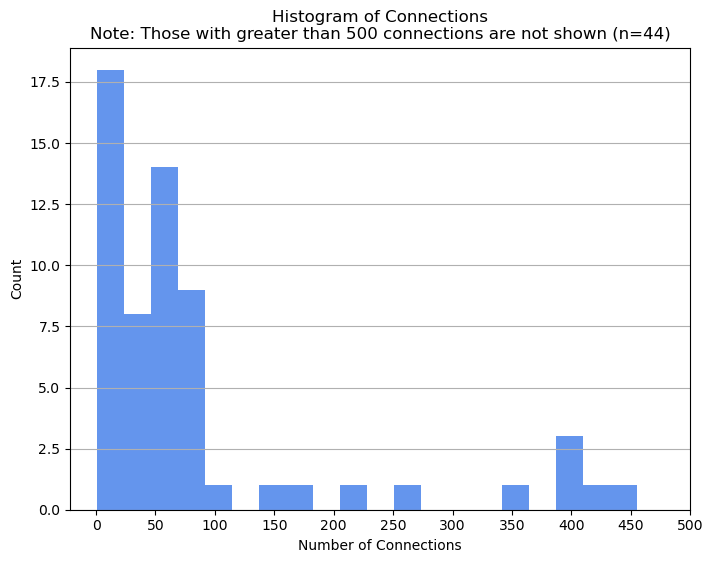

In [41]:
plt.figure(figsize=(8,6))
plt.hist(x=df_no500['connection'],
         color='cornflowerblue',
         bins=20)
plt.title('Histogram of Connections\nNote: Those with greater than 500 connections are not shown (n=44)')
plt.xlabel('Number of Connections')
plt.ylabel('Count')
plt.grid(which='both',axis='y')
plt.xticks(range(0,501,50)) # get xticks to appear every 50 connections

plt.savefig('figures/3_histogram_connections.pdf',bbox_inches='tight')
plt.savefig('figures/3_histogram_connections.jpg',bbox_inches='tight')
plt.savefig('figures/3_histogram_connections.png',bbox_inches='tight')

plt.show()

### Boxplot of Connections

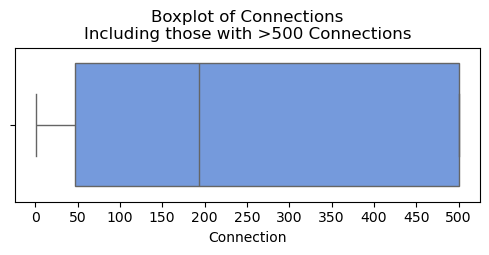

In [40]:
plt.figure(figsize=(6,2))
sns.boxplot(x=df['connection'],color='cornflowerblue')
plt.title('Boxplot of Connections\nIncluding those with >500 Connections')
plt.xlabel('Connection')
plt.xticks(range(0,501,50))

plt.savefig('figures/3_boxplot_connections.pdf',bbox_inches='tight')
plt.savefig('figures/3_boxplot_connections.jpg',bbox_inches='tight')
plt.savefig('figures/3_boxplot_connections.png',bbox_inches='tight')

plt.show()

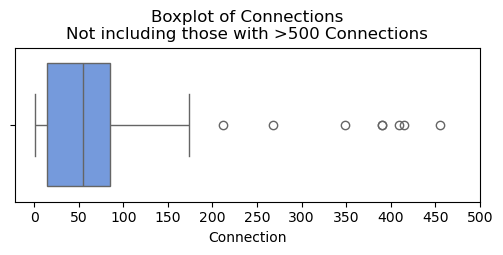

In [39]:
plt.figure(figsize=(6,2))
plt.tight_layout()
sns.boxplot(x=df_no500['connection'],color='cornflowerblue')
plt.title('Boxplot of Connections\nNot including those with >500 Connections')
plt.xlabel('Connection')
plt.xticks(range(0,501,50))

plt.savefig('figures/3_boxplot_no500.pdf',bbox_inches='tight')
plt.savefig('figures/3_boxplot_no500.jpg',bbox_inches='tight')
plt.savefig('figures/3_boxplot_no500.png',bbox_inches='tight')

plt.show()

### Map of Observations

In [17]:
df['location'].value_counts()

location
Kanada                                 12
Raleigh-Durham, North Carolina Area     8
Houston, Texas Area                     8
Greater New York City Area              7
Houston, Texas                          7
Denton, Texas                           6
San Francisco Bay Area                  5
Greater Philadelphia Area               5
İzmir, Türkiye                          4
Lake Forest, California                 4
Atlanta, Georgia                        4
Chicago, Illinois                       2
Austin, Texas Area                      2
Greater Atlanta Area                    2
Amerika Birleşik Devletleri             2
Long Beach, California                  1
Milpitas, California                    1
Greater Chicago Area                    1
Torrance, California                    1
Greater Los Angeles Area                1
Bridgewater, Massachusetts              1
Lafayette, Indiana                      1
Kokomo, Indiana Area                    1
Las Vegas, Nevada Area   

In [18]:
# number of unique locations in dataset
df['location'].nunique()

41

This is not terrible. I'd like to get the location for each municipality to create a chloropleth map of the locations.

First step is to clean this column to make it easier to get the locations. We won't go fully intense with the geospatial information, so if the city says "Greater CITY Area," I'll just make that "CITY" to simplify things.

In [19]:
# data from here:
# https://github.com/kelvins/US-Cities-Database
cities=pd.read_csv('../data/us_cities.csv')
cities.head(3)

,ID,STATE_CODE,STATE_NAME,CITY,COUNTY,LATITUDE,LONGITUDE
0,1,AK,Alaska,Adak,Aleutians West,55.999722,-161.207778
1,2,AK,Alaska,Akiachak,Bethel,60.891854,-161.392330
2,3,AK,Alaska,Akiak,Bethel,60.890632,-161.199325


In [20]:
# find cities
_=cities[cities['CITY'].str.contains('Katy')]
_

# I also used Google Earth Pro

,ID,STATE_CODE,STATE_NAME,CITY,COUNTY,LATITUDE,LONGITUDE
25488,25489,TX,Texas,Katy,Fort Bend,29.750893,-95.811675
25489,25490,TX,Texas,Katy,Harris,29.819922,-95.729267


In [21]:
city_loc_map={
    'Kanada':{'lat':45.424721,'lon':-75.695,'name':'Canada'}, # choosing Ottowa
    'Raleigh-Durham, North Carolina Area':{'lat':35.772701,'lon':-78.632439,'name':'Raleigh'},
    'Houston, Texas Area':{'lat':29.765200,'lon':-95.365700,'name':'Houston'},
    'Greater New York City Area':{'lat':40.748380,'lon':-73.996705,'name':'New_York_City'},
    'Houston, Texas':{'lat':29.765200,'lon':-95.365700,'name':'Houston'},
    'Denton, Texas':{'lat':33.22893,'lon':-97.131436,'name':'Denton'},
    'San Francisco Bay Area':{'lat':37.775,'lon':-122.4183,'name':'San_Francisco'},
    'Greater Philadelphia Area':{'lat':39.864998,'lon':-75.275196,'name':'Philadelphia'},
    'İzmir, Türkiye':{'lat':38.4228,'lon':27.1404,'name':'İzmir'},
    'Lake Forest, California':{'lat':33.640015,'lon':-117.68819,'name':'Lake_Forest_CA'},
    'Atlanta, Georgia':{'lat':33.7564,'lon':-84.3918,'name':'Atlanta'},
    'Chicago, Illinois':{'lat':41.885847,'lon':-87.618123,'name':'Chicago'},
    'Austin, Texas Area':{'lat':30.2303,'lon':-97.7144,'name':'Austin'},
    'Greater Atlanta Area':{'lat':33.7564,'lon':-84.3918,'name':'Atlanta'},
    'Amerika Birleşik Devletleri':{'lat':39.833333,'lon':-98.583333,'name':'United_States'},
    'Long Beach, California':{'lat':33.7705,'lon':-118.1885,'name':'Long_Beach'},
    'Milpitas, California':{'lat':37.436491,'lon':-121.892885,'name':'Milpitas'},
    'Greater Chicago Area':{'lat':41.885847,'lon':-87.618123,'name':'Chicago'},
    'Torrance, California':{'lat':33.826817,'lon':-118.31183,'name':'Torrance'},
    'Greater Los Angeles Area':{'lat':33.973093,'lon':-118.247896,'name':'Los_Angeles'},
    'Bridgewater, Massachusetts':{'lat':41.977341,'lon':-70.97234,'name':'Bridgewater_MA'},
    'Lafayette, Indiana':{'lat':40.417743,'lon':-86.888358,'name':'Lafayette_IN'},
    'Kokomo, Indiana Area':{'lat':40.498840,'lon':-86.145273,'name':'Kokomo_IN'},
    'Las Vegas, Nevada Area':{'lat':36.172082,'lon':-115.122366,'name':'Las_Vegas'},
    'Cape Girardeau, Missouri':{'lat':37.31685,'lon':-89.545861,'name':'Cape_Girardeau'},
    'Gaithersburg, Maryland':{'lat':39.14187,'lon':-77.188993,'name':'Gaithersburg'},
    'Baltimore, Maryland':{'lat':39.294630,'lon':-76.625203,'name':'Baltimore_MD'},
    'Dallas/Fort Worth Area':{'lat':32.778,'lon':-96.7968,'name':'Dallas'},
    'Highland, California':{'lat':34.126969,'lon':-117.208717,'name':'Highland_CA'},
    'Los Angeles, California':{'lat':33.973093,'lon':-118.247896,'name':'Los_Angeles'},
    'Chattanooga, Tennessee Area':{'lat':35.045500,'lon':-85.308100,'name':'Chattanooga'},
    'Myrtle Beach, South Carolina Area':{'lat':33.758701,'lon':-78.804448,'name':'Myrtle_Beach'},
    'Baton Rouge, Louisiana Area':{'lat':30.450731,'lon':-91.186954,'name':'Baton_Rouge'},
    'New York, New York':{'lat':40.748380,'lon':-73.996705,'name':'New_York_City'},
    'San Jose, California':{'lat':37.389400,'lon':-121.886800,'name':'San_Jose'},
    'Greater Boston Area':{'lat':42.357603,'lon':-71.068432,'name':'Boston_MA'},
    'Monroe, Louisiana Area':{'lat':32.528551,'lon':-92.106104,'name':'Monroe_LA'},
    'Virginia Beach, Virginia':{'lat':36.8527,'lon':-75.9783,'name':'Virginia_Beach'},
    'Greater Grand Rapids, Michigan Area':{'lat':42.970400,'lon':-85.673800,'name':'Grand_Rapids_MI'},
    'Jackson, Mississippi Area':{'lat':32.293502,'lon':-90.186655,'name':'Jackson_MS'},
    'Katy, Texas':{'lat':29.7828,'lon':-95.8212,'name':'Katy_TX'}
}

city_loc_map = pd.DataFrame(city_loc_map).T.reset_index(names="original_name")
city_loc_map = city_loc_map.drop(columns=['index'], errors='ignore') 

In [22]:
city_loc_map.head()

,original_name,lat,lon,name
0,Kanada,45.424721,-75.695,Canada
1,"Raleigh-Durham, North Carolina Area",35.772701,-78.632439,Raleigh
2,"Houston, Texas Area",29.7652,-95.3657,Houston
3,Greater New York City Area,40.74838,-73.996705,New_York_City
4,"Houston, Texas",29.7652,-95.3657,Houston


In [23]:
# merge dataframes to include new spatial information
if 'lat' not in df.columns:
    print('Merging tables')
    df=df.merge(city_loc_map[['original_name','lat','lon','name']],
               left_on='location',
               right_on='original_name',
               how='left')

    df=df.drop(columns=['original_name'])

print('df has already been merged')
df.head(3)

Merging tables
df has already been merged


,id,job_title,location,connection,lat,lon,name
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,29.7652,-95.3657,Houston
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500,45.424721,-75.695,Canada
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,35.772701,-78.632439,Raleigh


In [24]:
# check if there's an equal number of latitudes for the city names
df['lat'].value_counts().count()==df['name'].value_counts().count()

True

Excellent! We successfully added the city location. Now let's make a chloropleth map (or something similar) showing the geographic distribution of the applicants.

We almost forgot: let's now make a table that shows the sum of applicants at each location.

In [25]:
con=duckdb.connect(database=':memory:')
con.register('df',df)
ct_cities=con.execute('''
select
    count(name) as ct
    ,lat
    ,lon
    ,name
from df
group by name,lat,lon;
''').fetchdf()
con.close()
ct_cities.head()

,ct,lat,lon,name
0,1,32.293502,-90.186655,Jackson_MS
1,1,36.852700,-75.978300,Virginia_Beach
2,2,39.833333,-98.583333,United_States
3,1,37.436491,-121.892885,Milpitas
4,1,29.782800,-95.821200,Katy_TX


In [26]:
# downloaded from something like
# https://github.com/georgique/world-geojson
borders=gpd.read_file('../data/world_borders.geojson')
borders.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


I'll make two maps, one of North America and another of Tükiye.

In [27]:
con=duckdb.connect(database=':memory:')
con.register('ct_cities',ct_cities)
ct_cities_na=con.execute('''
select
    *
from ct_cities
where lon<27;
''').fetchdf()
con.close()
ct_cities_na.head()

,ct,lat,lon,name
0,1,32.293502,-90.186655,Jackson_MS
1,1,36.852700,-75.978300,Virginia_Beach
2,2,39.833333,-98.583333,United_States
3,1,37.436491,-121.892885,Milpitas
4,1,29.782800,-95.821200,Katy_TX


In [28]:
con=duckdb.connect(database=':memory:')
con.register('ct_cities',ct_cities)
ct_cities_tk=con.execute('''
select
    *
from ct_cities
where lon>27;
''').fetchdf()
con.close()
ct_cities_tk.head()

,ct,lat,lon,name
0,4,38.4228,27.1404,İzmir


In [29]:
# us states geojson from here:
# https://github.com/PublicaMundi/\
# MappingAPI/blob/master/data/geojson/us-states.json
states=gpd.read_file('../data/us-states.json')
states.head()

,id,name,density,geometry
0,01,Alabama,94.650,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,02,Alaska,1.264,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,04,Arizona,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


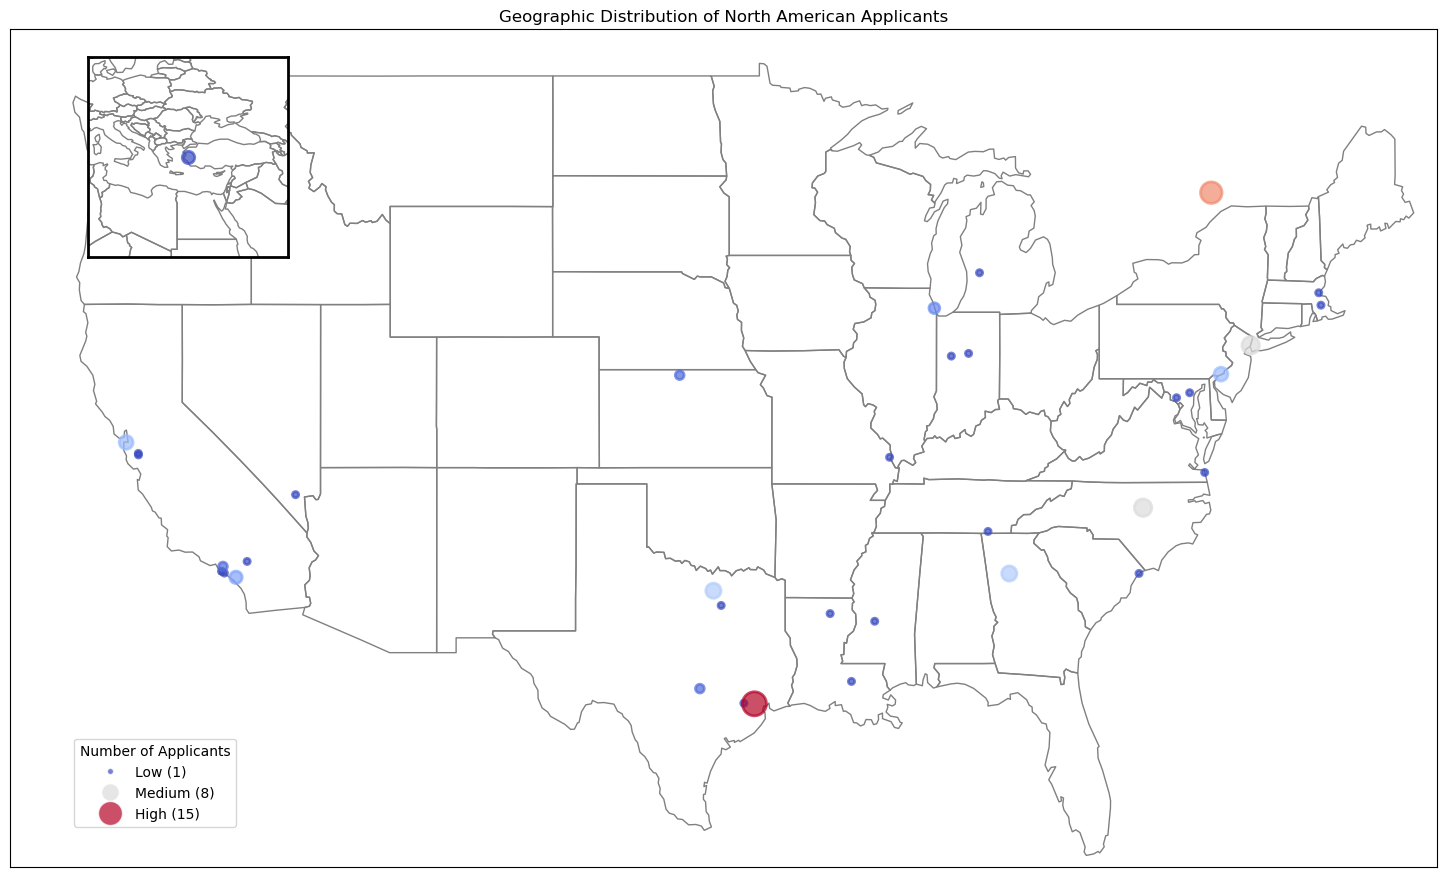

In [32]:
# set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 10))
plt.title('Geographic Distribution of North American Applicants') 
plt.tight_layout()

# hide x and y axis labels for cleaner map display
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# plot US states
states.plot(ax=ax, edgecolor='grey', facecolor='none')

# plot scatter points for North America data
scale_factor = 20  # to make it more visible
alpha_ = 0.7  # consistent alpha value

scatter_na = ax.scatter(
    x=ct_cities_na['lon'], 
    y=ct_cities_na['lat'],
    s=ct_cities_na['ct'] * scale_factor,
    c=ct_cities_na['ct'],
    cmap='coolwarm',
    linewidths=2,
    alpha=alpha_
)

# set limits for a focused map view on North America
ax.set_xlim([ct_cities_na['lon'].min() - 5, ct_cities_na['lon'].max() + 5])
ax.set_ylim([ct_cities_na['lat'].min() - 5, ct_cities_na['lat'].max() + 5])

## add inset for Türkiye data
axins = inset_axes(ax, width=3, height=2, loc='upper left', borderpad=2)
axins.spines['top'].set_linewidth(2)
axins.spines['bottom'].set_linewidth(2)
axins.spines['left'].set_linewidth(2)
axins.spines['right'].set_linewidth(2)
axins.get_xaxis().set_visible(False)
axins.get_yaxis().set_visible(False)

# plot the borders of Türkiye's neighboring countries
borders.plot(ax=axins, edgecolor='grey', facecolor='none')

# plot scatter points for Türkiye data in the inset
scatter_tk = axins.scatter(
    x=ct_cities_tk['lon'], 
    y=ct_cities_tk['lat'],
    s=ct_cities_tk['ct'] * scale_factor,
    c=ct_cities_tk['ct'],
    cmap='coolwarm',
    linewidths=2,
    alpha=alpha_
)

# set limits for a focused view of Türkiye in the inset
axins.set_xlim([ct_cities_tk['lon'].min() - 20, ct_cities_tk['lon'].max() + 20])
axins.set_ylim([ct_cities_tk['lat'].min() - 20, ct_cities_tk['lat'].max() + 20])

## custom legend entries using Line2D
# define representative sizes and values for legend
min_ = min(ct_cities_na['ct'])
max_ = max(ct_cities_na['ct'])
middle = (min_ + max_) / 2

size_labels = [min_, middle, max_]
colors = [min_, middle, max_]

# use color map to assign color to each representative count
cmap = plt.cm.coolwarm
color_legend = [cmap((value - min_) / (max_ - min_)) for value in colors]

# create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Low ({min_})', 
#            using square root so that the marker size area scales appropriately with original scale factor
           markerfacecolor=color_legend[0], markersize=(size_labels[0] * scale_factor) ** 0.5, alpha=alpha_),
    Line2D([0], [0], marker='o', color='w', label=f'Medium ({middle:.0f})', 
           markerfacecolor=color_legend[1], markersize=(size_labels[1] * scale_factor) ** 0.5, alpha=alpha_),
    Line2D([0], [0], marker='o', color='w', label=f'High ({max_})', 
           markerfacecolor=color_legend[2], markersize=(size_labels[2] * scale_factor) ** 0.5, alpha=alpha_)
]

# add the custom legend to the plot
ax.legend(handles=legend_elements, 
          title="Number of Applicants", 
          loc="lower left", 
          frameon=True,
          bbox_to_anchor=(0.04,0.04))

plt.savefig('figures/3_map.pdf')
plt.savefig('figures/3_map.jpg')
plt.savefig('figures/3_map.png')

plt.show()

## Preprocessing Language Data

Then we'll apply the city boundary data to each city, using the data from [this repo](https://github.com/drei01/geojson-world-cities/tree/master).

I'm following a tutorial of SpatialSQL + DuckDB from [here](https://blobs.duckdb.org/papers/duckdb-spatial-geopython-2024.pdf).

In [31]:
# install and load spatial extension
dd.execute('INSTALL spatial')
dd.execute('LOAD spatial')

# load cities geojson
cities=dd.read_json('../data/cities.geojson')

# show schema of the "rel" relation
dd.sql('summarize cities').select('column_name','column_type').show()

NameError: name 'dd' is not defined

In [ ]:
result=dd.execute('''
select *
from read_json_auto('../data/cities.geojson')
limit 10
''').df()

result

In [ ]:
dd.sql('summarize rel').
    '''
select *
from rel
limit 5
''').show()

In [ ]:
df[df['connection']<150].count().iloc[0]

In [ ]:
df[df['connection']>150].count().iloc[0]

In [ ]:
print(f"{df[df['connection']<150].sum()}")

Most observations have more than 500 connections.